## TASK 6

### Import the required packages  
In this cell the required packages for the task are imported.

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import random
from skimage import morphology

### Import the images  
In this cell the mask from Task 5 is imported.

(2816, 2816)

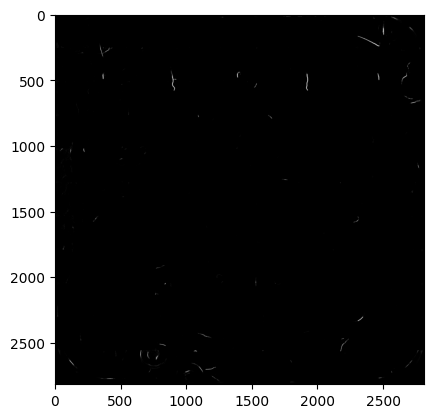

In [2]:
#import the first image
path = 'Kaggle Masks 5/test_image_14_root_mask.png'
mask = cv2.imread(path, cv2.IMREAD_GRAYSCALE) 
plt.imshow(mask, cmap='grey')
mask.shape

## Code Overview: Drawing Rectangles on a Mask

This code draws five sequential rectangles on a mask image, each offset horizontally from the previous one. Key steps:

1. **Rectangle Parameters**:
   - Define top-left and bottom-right coordinates, color, and thickness for each rectangle.

2. **Rectangle Drawing**:
   - Use `cv2.rectangle()` to draw each rectangle with calculated positions.

3. **Display the Mask**:
   - Visualize the updated mask with `matplotlib`.

The rectangles are evenly spaced and provide a clear visual representation on the mask.


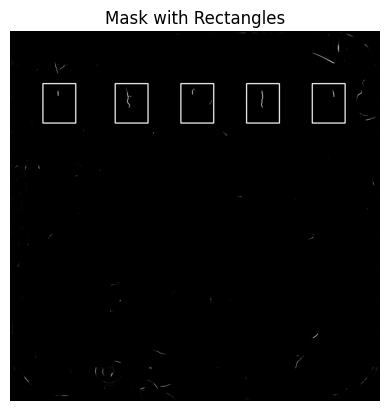

In [11]:
# Example: Top-left corner and bottom-right corner
top_left_1 = (250, 400)  # top left corner
bottom_right_1 = (500, 700)  # bottom right corner
color = (255, 0, 0)  # White color for grayscale image
thickness = 8  # Thickness of the rectangle border
# Draw the rectangle on the mask
cv2.rectangle(mask, top_left_1, bottom_right_1, color, thickness)

# Calculate and draw the second rectangle
top_left_2 = (top_left_1[0] + 550, top_left_1[1])
bottom_right_2 = (bottom_right_1[0] + 550, bottom_right_1[1])
cv2.rectangle(mask, top_left_2, bottom_right_2, color, thickness)

# Calculate and draw the third rectangle
top_left_3 = (top_left_2[0] + 500, top_left_2[1])
bottom_right_3 = (bottom_right_2[0] + 500, bottom_right_2[1])
cv2.rectangle(mask, top_left_3, bottom_right_3, color, thickness)

# Calculate and draw the fourth rectangle
top_left_4 = (top_left_3[0] + 500, top_left_3[1])
bottom_right_4 = (bottom_right_3[0] + 500, bottom_right_3[1])
cv2.rectangle(mask, top_left_4, bottom_right_4, color, thickness)

# Calculate and draw the fifth rectangle
top_left_5 = (top_left_4[0] + 500, top_left_4[1])
bottom_right_5 = (bottom_right_4[0] + 500, bottom_right_4[1])
cv2.rectangle(mask, top_left_5, bottom_right_5, color, thickness)

# Display the modified mask
plt.imshow(mask, cmap='gray')
plt.title('Mask with Rectangles')
plt.axis('off')  # Hide axes
plt.show()

## Code Overview: Root Segmentation and Saving Largest Components

This code segments individual roots from binary masks and processes specified rectangular areas to save the largest connected root component or a blank image if no components are found.

### Key Steps:
1. **Segment Individual Roots**:
   - Converts the mask to binary.
   - Removes small objects (noise).
   - Performs connected component analysis to label individual roots.

2. **Process Rectangles in Masks**:
   - Iterates over rectangles in each mask image.
   - Extracts the region corresponding to each rectangle.
   - Identifies and saves the largest root component in the region.

3. **Saving Results**:
   - For each rectangle:
     - Saves a binary mask of the largest root component.
     - Saves a blank image if no components are found.

4. **Output**:
   - Results are saved in the `output_folder`, with filenames indicating the corresponding rectangle.

This process is particularly useful for isolating and analyzing individual root structures within predefined regions in an image dataset.


In [12]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import remove_small_objects
# Define the function to segment individual roots
def segment_individual_roots(root_mask):
    """
    Segments individual roots from a binary root mask.

    Args:
    - root_mask: Binary image with root pixels (255) and background pixels (0).

    Returns:
    - labeled_mask: Image where each root is assigned a unique label (integer).
    - num_roots: Number of unique roots identified.
    """
    # Ensure the mask is binary (values 0 and 255)
    binary_mask = np.where(root_mask > 127, 255, 0).astype(np.uint8)

    # Remove small objects
    cleaned_mask = remove_small_objects(binary_mask.astype(bool), min_size=10)
    cleaned_mask = cleaned_mask.astype(np.uint8)  # Convert back to uint8

    # Connected components analysis
    num_labels, labeled_mask = cv2.connectedComponents(cleaned_mask, connectivity=8)
    # return the labeled mask and the number of roots
    return labeled_mask, num_labels - 1  # Subtract 1 to exclude background

# function to save the largest root in each rectangle
def save_largest_root_in_rectangles(input_folder, output_folder, rectangles):
    """
    Processes multiple images from the input folder, saves the largest connected
    component for each rectangle in each image, or saves a blank image if no
    components are found.

    Args:
    - input_folder: Path to the folder containing mask images.
    - output_folder: Path to the folder where the results will be saved.
    - rectangles: List of tuples representing rectangles,
                  where each tuple is ((x1, y1), (x2, y2)).

    Returns:
    - None
    """
    # Ensure the output directory exists
    os.makedirs(output_folder, exist_ok=True)

    # Iterate over all images in the input folder
    for filename in os.listdir(input_folder):
        if filename.endswith(".png") or filename.endswith(".jpg"):
            # Load the binary root mask
            mask_path = os.path.join(input_folder, filename)
            root_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

            # Segment individual roots
            labeled_mask, num_roots = segment_individual_roots(root_mask)

            # Process each rectangle for the current mask
            for i, (top_left, bottom_right) in enumerate(rectangles):
                x1, y1 = top_left
                x2, y2 = bottom_right

                # Extract the rectangle area from the labeled mask
                rectangle_area = labeled_mask[y1:y2, x1:x2]

                # Get unique labels of components in the rectangle area
                unique_labels, counts = np.unique(rectangle_area, return_counts=True)

                # Exclude the background label (0)
                component_sizes = {label: size for label, size in zip(unique_labels, counts) if label != 0}

                # Prepare output naming
                base_name = os.path.splitext(filename)[0]  # Get the name without extension
                plant_name = f"{base_name}_plant_{i+1}.png"
                output_path = os.path.join(output_folder, plant_name)

                if component_sizes:
                    # Find the largest connected component within the rectangle
                    largest_label = max(component_sizes, key=component_sizes.get)

                    # Create a binary mask for the largest connected component
                    largest_component_mask = (labeled_mask == largest_label).astype(np.uint8) * 255

                    # Save the mask for the largest connected component
                    cv2.imwrite(output_path, largest_component_mask)
                    print(f"Saved largest connected component: {output_path}")
                else:
                    # Save a blank (black) image if no components are found
                    blank_image = np.zeros_like(root_mask, dtype=np.uint8)
                    cv2.imwrite(output_path, blank_image)
                    print(f"No connected components found. Saved blank image: {output_path}")

### Define the rctangle positions and use the function with the input and output folders

In [13]:

# Define the rectangles
rectangles = [
    ((250, 400), (500, 800)),  # Rectangle 1
    ((800, 400), (1050, 800)),  # Rectangle 2
    ((1300, 400), (1550, 800)), # Rectangle 3
    ((1800, 400), (2050, 800)),# Rectangle 4
    ((2300, 400), (2550, 800)) # Rectangle 5
]

input_folder = 'Kaggle Masks 5'
# Define the output directory
output_dir = "Kaggle Plants 5"
    
# Save roots in rectangles
save_largest_root_in_rectangles(input_folder, output_dir, rectangles)

Saved largest connected component: Kaggle Plants 5/test_image_18_root_mask_plant_1.png
Saved largest connected component: Kaggle Plants 5/test_image_18_root_mask_plant_2.png
No connected components found. Saved blank image: Kaggle Plants 5/test_image_18_root_mask_plant_3.png
Saved largest connected component: Kaggle Plants 5/test_image_18_root_mask_plant_4.png
Saved largest connected component: Kaggle Plants 5/test_image_18_root_mask_plant_5.png
Saved largest connected component: Kaggle Plants 5/test_image_14_root_mask_plant_1.png
Saved largest connected component: Kaggle Plants 5/test_image_14_root_mask_plant_2.png
Saved largest connected component: Kaggle Plants 5/test_image_14_root_mask_plant_3.png
Saved largest connected component: Kaggle Plants 5/test_image_14_root_mask_plant_4.png
Saved largest connected component: Kaggle Plants 5/test_image_14_root_mask_plant_5.png
Saved largest connected component: Kaggle Plants 5/test_image_12_root_mask_plant_1.png
Saved largest connected comp